# **Spam Detection using Deep Learning Algorithms**

>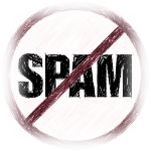

This notebook consists of evaluation of deep learning algorithms like LSTM and biLSTM with and without hyperparameters. The models are evaluated to find the best algorithm for the given dataset and given task. The dataset is taken from Kaggle.com. 
The goal is to find  the algorithm with maximum accuracy and minimum loss.

Also, each model is tested with an actual spam email I received to my inbox. It is observed that all the models detect the spam message accurately.

## Importing All the dependencies

In [55]:
import tensorflow as tf

In [99]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,GlobalMaxPooling1D, Input, LSTM, Embedding,Dropout,Bidirectional
import re as re

## Importing the dataset and preprocessing
Dataset taken from : https://www.kaggle.com/venky73/spam-mails-dataset

In [57]:
df=pd.read_csv('spam_ham_dataset.csv', encoding='ISO-8859-1')

In [58]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [59]:
df = df.drop(["Unnamed: 0"], axis=1)
df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [60]:
#removing html elements from the text column
def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
df['text']=df['text'].apply(lambda cw : remove_tags(cw))
df['text']=df['text'].replace('\n',' ', regex=True)
df['text']=df['text'].replace('\r',' ', regex=True)
df['text']=df['text'].replace('Subject:',' ', regex=True)
df['text']=df['text'].replace('nbsp',' ', regex=True)
df['text']=df['text'].replace('re :',' ', regex=True)
df.head()

,label,text,label_num
0,ham,enron methanol ; meter # : 988291 this is a...,0
1,ham,"hpl nom for january 9 , 2001 ( see attached...",0
2,ham,"neon retreat ho ho ho , we ' re around to t...",0
3,spam,"photoshop , windows , office . cheap . main ...",1
4,ham,indian springs this deal is to book the t...,0


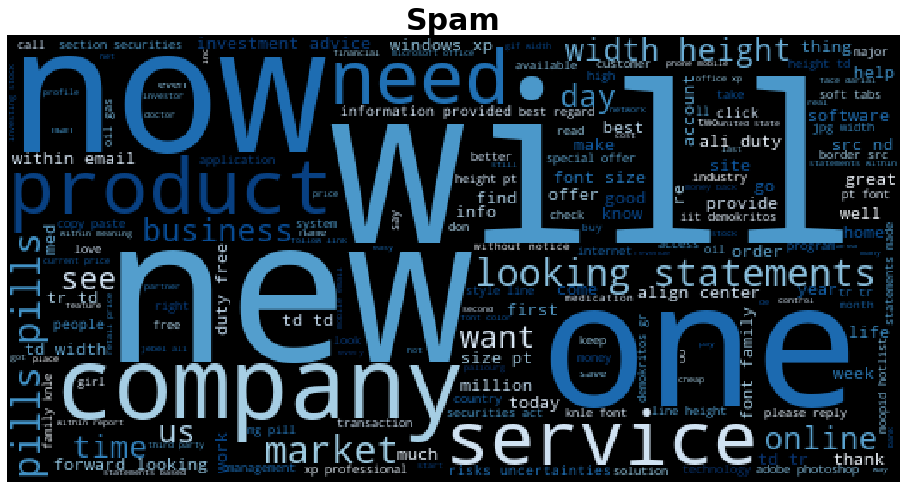

In [61]:
# spam
spam_message_df=df[df.label=="spam"]
ham_message_df=df[df.label=="ham"]
ham_messages=" ".join(spam_message_df.text.to_numpy().tolist())
spam_messages=" ".join(ham_message_df.text.to_numpy().tolist())
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
ham_wordcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,  colormap='Blues').generate(ham_messages)
plt.figure(figsize=(16,10))
plt.imshow(ham_wordcloud, interpolation='nearest')
plt.title('Spam',fontweight='bold',fontsize=30)
plt.axis('off') # turn off axis
plt.show()

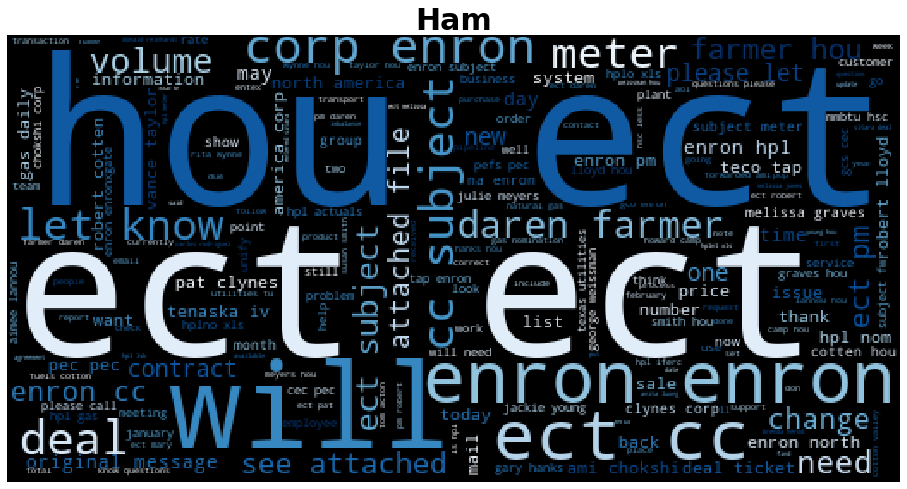

In [62]:
#wordclouds ham
ham_messages=" ".join(df[df.label=="ham"].text.to_numpy().tolist())
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
ham_wordcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,  colormap='Blues').generate(ham_messages)
plt.figure(figsize=(16,10))
plt.imshow(ham_wordcloud, interpolation='nearest')
plt.title('Ham',fontweight='bold',fontsize=30)
plt.axis('off') # turn off axis
plt.show()

In [63]:
df.head()

,label,text,label_num
0,ham,enron methanol ; meter # : 988291 this is a...,0
1,ham,"hpl nom for january 9 , 2001 ( see attached...",0
2,ham,"neon retreat ho ho ho , we ' re around to t...",0
3,spam,"photoshop , windows , office . cheap . main ...",1
4,ham,indian springs this deal is to book the t...,0


In [64]:

Y = df['label_num'].values

In [65]:
x_train,x_test,y_train,y_test=train_test_split(df['text'],Y,test_size=0.33)

In [66]:
MAX_VOCAB_SIZE = 20000
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)
sequences_train=tokenizer.texts_to_sequences(x_train)
sequences_test=tokenizer.texts_to_sequences(x_test)

In [67]:
type(x_test)

pandas.core.series.Series

In [68]:
# get word -> integer mapping
tokenidx = tokenizer.word_index
V = len(tokenidx)
print('%s unique tokens.' % V)

39539 unique tokens.


In [69]:
## Padding to get input of the form NxT for LSTM
x_train_pad=pad_sequences(sequences_train)
print('Shape x_train_pad:', x_train_pad.shape)

T=x_train_pad.shape[1]
x_test_pad=pad_sequences(sequences_test, maxlen=T)
print('Shape x_test_pad:', x_test_pad.shape)

Shape x_train_pad: (3464, 2601)
Shape x_test_pad: (1707, 2601)


LSTM model training

In [70]:
#embedding dimension vectors and indexing the vector
D=20

#Hidden vector M
M=15

i=Input(shape=(T,))

#V+1 as 0th place is not used due to value for missing tokens
X=Embedding(V+1,D)(i)
X=LSTM(M,return_sequences=True)(X)
X=GlobalMaxPooling1D()(X)
X=Dense(1,activation='sigmoid')(X)

model=Model(i,X)

In [71]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
r=model.fit(x_train_pad,y_train,validation_data=(x_test_pad,y_test),epochs=10)

Epoch 1/10
109/109 [==============================] - 31s 266ms/step - loss: 0.5695 - accuracy: 0.7090 - val_loss: 0.3661 - val_accuracy: 0.7610
Epoch 2/10
109/109 [==============================] - 28s 254ms/step - loss: 0.2123 - accuracy: 0.9509 - val_loss: 0.1501 - val_accuracy: 0.9590
Epoch 3/10
109/109 [==============================] - 28s 256ms/step - loss: 0.1026 - accuracy: 0.9804 - val_loss: 0.0968 - val_accuracy: 0.9760
Epoch 4/10
109/109 [==============================] - 28s 254ms/step - loss: 0.0709 - accuracy: 0.9879 - val_loss: 0.0902 - val_accuracy: 0.9777
Epoch 5/10
109/109 [==============================] - 29s 263ms/step - loss: 0.0410 - accuracy: 0.9951 - val_loss: 0.0792 - val_accuracy: 0.9801
Epoch 6/10
109/109 [==============================] - 28s 254ms/step - loss: 0.0275 - accuracy: 0.9968 - val_loss: 0.0784 - val_accuracy: 0.9795
Epoch 7/10
109/109 [==============================] - 27s 252ms/step - loss: 0.0186 - accuracy: 0.9983 - val_loss: 0.0801 - val_ac

Evaluation

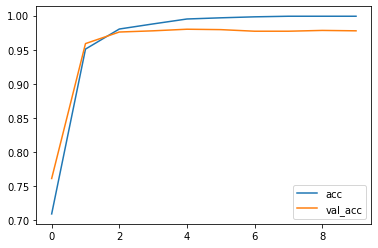

In [72]:
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()

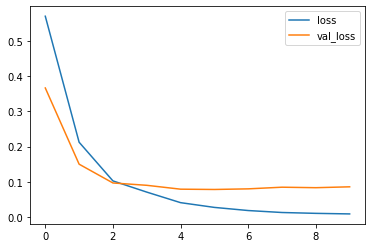

In [73]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [74]:
model.evaluate(x_test_pad, y_test)

54/54 [==============================] - 7s 124ms/step - loss: 0.0859 - accuracy: 0.9777


[0.08588651567697525, 0.9777387380599976]

In [75]:
predict_msg = ["DHL: * Your order # 07u # will * reach you shortly. https://hakurei-shrine.icu/0/?ew8e1um.cnt"]

## Testing the model with real data

In [76]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =T)
    print("\033[1m Message:\033[0m "+str(predict_msg[0]))
    return ("This message is a: " +np.where(model.predict(padded)>0.5,"Spam","Ham")[0][0])
predict_spam(predict_msg)

 Message: DHL: * Your order # 07u # will * reach you shortly. https://hakurei-shrine.icu/0/?ew8e1um.cnt


'This message is a: Spam'

## **Improving the model**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


40.822440087145964

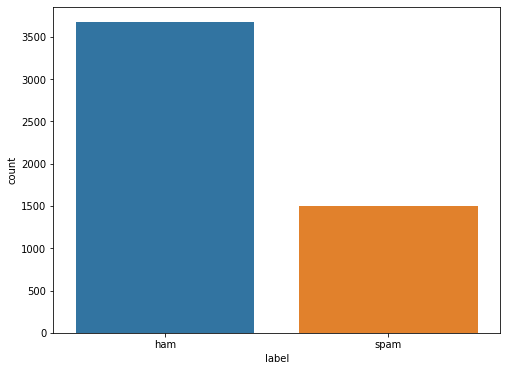

In [77]:
# we can observe imbalance data here 
import seaborn as sns
plt.figure(figsize=(8,6))
sns.countplot(df.label)
# Percentage of spam messages
(len(spam_message_df)/len(ham_message_df))*100 # 15.48%

# **Downsampling**

(1499, 3) (1499, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


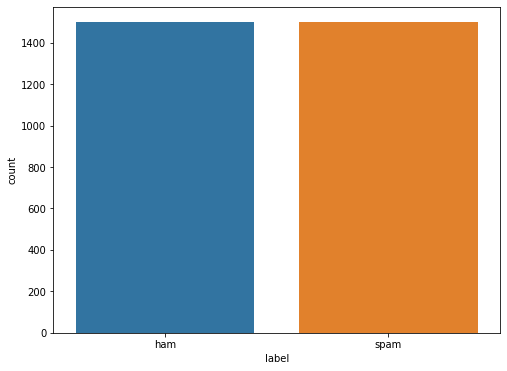

In [78]:
ham_messages_downsample = ham_message_df.sample(n = len(spam_message_df), random_state =10)
print(ham_messages_downsample.shape, spam_message_df.shape)
plt.figure(figsize=(8,6))
df_downsampled=ham_messages_downsample.append(spam_message_df).reset_index(drop=True)
sns.countplot(df_downsampled.label)

In [79]:
df_downsampled

,label,text,label_num
0,ham,"base gas roll thanks , gg from : luis a...",0
1,ham,industrials i leave this with you . my ta...,0
2,ham,tenaska iv outage update please note that t...,0
3,ham,cynergy ( apache ) stacey / daren - - - - l...,0
4,ham,freedom ? ? ? bammelyoungfamilies - - - - ...,0
...,...,...,...
2993,spam,pictures streamlined denizen ajar chased h...,1
2994,spam,penny stocks are about timing nomad interna...,1
2995,spam,anomaly boys from 3881 uosda apaproved mled...,1
2996,spam,slutty milf wants to meet you take that ! ...,1


In [80]:
Y = df_downsampled['label_num'].values
x_train,x_test,y_train,y_test=train_test_split(df_downsampled['text'],Y,test_size=0.33)
MAX_VOCAB_SIZE = 20000
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)
sequences_train=tokenizer.texts_to_sequences(x_train)
sequences_test=tokenizer.texts_to_sequences(x_test)
tokenidx = tokenizer.word_index
V = len(tokenidx)
x_train_pad=pad_sequences(sequences_train)
T=x_train_pad.shape[1]
x_test_pad=pad_sequences(sequences_test, maxlen=T)

#embedding dimension vectors and indexing the vector
D=20

#Hidden vector M
M=15

i=Input(shape=(T,))

#V+1 as 0th place is not used due to value for missing tokens
X=Embedding(V+1,D)(i)
X=LSTM(M,return_sequences=True)(X)
X=GlobalMaxPooling1D()(X)
x=Dropout(0.2)(X)
X=Dense(1,activation='sigmoid')(X)

model=Model(i,X)

In [81]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
r=model.fit(x_train_pad,y_train,validation_data=(x_test_pad,y_test),epochs=10)

Epoch 1/10
63/63 [==============================] - 23s 293ms/step - loss: 0.6236 - accuracy: 0.8526 - val_loss: 0.4617 - val_accuracy: 0.9465
Epoch 2/10
63/63 [==============================] - 17s 265ms/step - loss: 0.3224 - accuracy: 0.9537 - val_loss: 0.2266 - val_accuracy: 0.9737
Epoch 3/10
63/63 [==============================] - 19s 298ms/step - loss: 0.1478 - accuracy: 0.9841 - val_loss: 0.1423 - val_accuracy: 0.9818
Epoch 4/10
63/63 [==============================] - 20s 316ms/step - loss: 0.0867 - accuracy: 0.9930 - val_loss: 0.1132 - val_accuracy: 0.9798
Epoch 5/10
63/63 [==============================] - 16s 254ms/step - loss: 0.0575 - accuracy: 0.9955 - val_loss: 0.1168 - val_accuracy: 0.9778
Epoch 6/10
63/63 [==============================] - 16s 254ms/step - loss: 0.0428 - accuracy: 0.9965 - val_loss: 0.1195 - val_accuracy: 0.9768
Epoch 7/10
63/63 [==============================] - 16s 253ms/step - loss: 0.0320 - accuracy: 0.9980 - val_loss: 0.1228 - val_accuracy: 0.9758

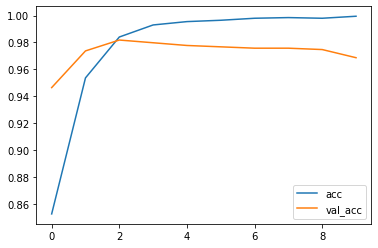

In [82]:
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()

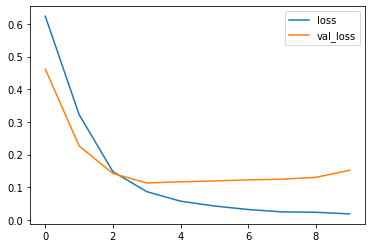

In [83]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [84]:
model.evaluate(x_test_pad, y_test)

31/31 [==============================] - 4s 114ms/step - loss: 0.1523 - accuracy: 0.9687


[0.15228748321533203, 0.9686868786811829]

In [85]:
predict_msg = ["DHL: * Your order # 07u # will * reach you shortly. https://hakurei-shrine.icu/0/?ew8e1um.cnt"]

In [86]:
predict_spam(predict_msg)

 Message: DHL: * Your order # 07u # will * reach you shortly. https://hakurei-shrine.icu/0/?ew8e1um.cnt


'This message is a: Spam'

# **Upsampling**

(3672, 3) (3672, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


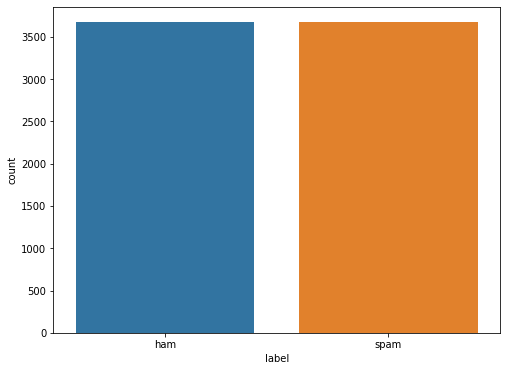

In [91]:
spam_messages_upsample = spam_message_df.sample(n = len(ham_message_df), random_state =10,replace=True)
print(ham_message_df.shape, spam_messages_upsample.shape)
plt.figure(figsize=(8,6))
df_upsampled=ham_message_df.append(spam_messages_upsample).reset_index(drop=True)
sns.countplot(df_upsampled.label)

In [92]:
Y = df_upsampled['label_num'].values
x_train,x_test,y_train,y_test=train_test_split(df_upsampled['text'],Y,test_size=0.33)
MAX_VOCAB_SIZE = 20000
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)
sequences_train=tokenizer.texts_to_sequences(x_train)
sequences_test=tokenizer.texts_to_sequences(x_test)
tokenidx = tokenizer.word_index
V = len(tokenidx)
x_train_pad=pad_sequences(sequences_train)
T=x_train_pad.shape[1]
x_test_pad=pad_sequences(sequences_test, maxlen=T)

#embedding dimension vectors and indexing the vector
D=20

#Hidden vector M
M=15

i=Input(shape=(T,))

#V+1 as 0th place is not used due to value for missing tokens
X=Embedding(V+1,D)(i)
X=LSTM(M,return_sequences=True)(X)
X=GlobalMaxPooling1D()(X)
x=Dropout(0.2)(X)
X=Dense(1,activation='sigmoid')(X)

model=Model(i,X)

In [93]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
r=model.fit(x_train_pad,y_train,validation_data=(x_test_pad,y_test),epochs=10)

Epoch 1/10
154/154 [==============================] - 69s 417ms/step - loss: 0.4393 - accuracy: 0.8679 - val_loss: 0.1561 - val_accuracy: 0.9790
Epoch 2/10
154/154 [==============================] - 60s 391ms/step - loss: 0.1003 - accuracy: 0.9837 - val_loss: 0.0769 - val_accuracy: 0.9814
Epoch 3/10
154/154 [==============================] - 69s 448ms/step - loss: 0.0562 - accuracy: 0.9898 - val_loss: 0.0944 - val_accuracy: 0.9752
Epoch 4/10
154/154 [==============================] - 60s 387ms/step - loss: 0.0469 - accuracy: 0.9898 - val_loss: 0.0624 - val_accuracy: 0.9864
Epoch 5/10
154/154 [==============================] - 69s 446ms/step - loss: 0.0342 - accuracy: 0.9959 - val_loss: 0.0693 - val_accuracy: 0.9851
Epoch 6/10
154/154 [==============================] - 59s 382ms/step - loss: 0.0240 - accuracy: 0.9984 - val_loss: 0.0624 - val_accuracy: 0.9872
Epoch 7/10
154/154 [==============================] - 58s 379ms/step - loss: 0.0176 - accuracy: 0.9988 - val_loss: 0.0640 - val_ac

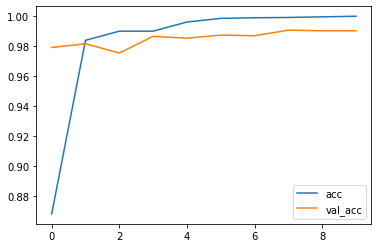

In [94]:
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()

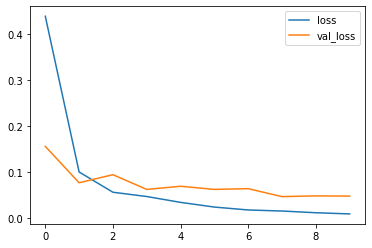

In [95]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [96]:
model.evaluate(x_test_pad, y_test)

76/76 [==============================] - 14s 186ms/step - loss: 0.0478 - accuracy: 0.9901


[0.047805044800043106, 0.9900990128517151]

In [97]:
predict_spam(predict_msg)

 Message: DHL: * Your order # 07u # will * reach you shortly. https://hakurei-shrine.icu/0/?ew8e1um.cnt


'This message is a: Spam'

It is observed that the LSTM with upsampling of dataset gives the best accuracy of 99% and a loss of  0.047.

## **biLSTM**

Testing biLSTM with upsampled dataset

In [108]:
from tensorflow.keras.layers import Bidirectional
Y = df_upsampled['label_num'].values
x_train,x_test,y_train,y_test=train_test_split(df_upsampled['text'],Y,test_size=0.33)
MAX_VOCAB_SIZE = 20000
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)
sequences_train=tokenizer.texts_to_sequences(x_train)
sequences_test=tokenizer.texts_to_sequences(x_test)
tokenidx = tokenizer.word_index
V = len(tokenidx)
x_train_pad=pad_sequences(sequences_train)
T=x_train_pad.shape[1]
x_test_pad=pad_sequences(sequences_test, maxlen=T)

#embedding dimension vectors and indexing the vector
D=20

#Hidden vector M
M=15

i=Input(shape=(T,))

#V+1 as 0th place is not used due to value for missing tokens
X=Embedding(V+1,D)(i)
X=Bidirectional(LSTM(M,return_sequences=True))(X)
X=GlobalMaxPooling1D()(X)
x=Dropout(0.2)(X)
X=Dense(1,activation='sigmoid')(X)

model=Model(i,X)

In [109]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
r=model.fit(x_train_pad,y_train,validation_data=(x_test_pad,y_test),epochs=10)

Epoch 1/10
154/154 [==============================] - 89s 523ms/step - loss: 0.4333 - accuracy: 0.8303 - val_loss: 0.1629 - val_accuracy: 0.9410
Epoch 2/10
154/154 [==============================] - 75s 490ms/step - loss: 0.0989 - accuracy: 0.9654 - val_loss: 0.0920 - val_accuracy: 0.9592
Epoch 3/10
154/154 [==============================] - 77s 498ms/step - loss: 0.0484 - accuracy: 0.9854 - val_loss: 0.0706 - val_accuracy: 0.9736
Epoch 4/10
154/154 [==============================] - 77s 500ms/step - loss: 0.0288 - accuracy: 0.9943 - val_loss: 0.0627 - val_accuracy: 0.9831
Epoch 5/10
154/154 [==============================] - 79s 511ms/step - loss: 0.0233 - accuracy: 0.9963 - val_loss: 0.0849 - val_accuracy: 0.9794
Epoch 6/10
154/154 [==============================] - 77s 499ms/step - loss: 0.0202 - accuracy: 0.9965 - val_loss: 0.0474 - val_accuracy: 0.9860
Epoch 7/10
154/154 [==============================] - 79s 512ms/step - loss: 0.0076 - accuracy: 0.9992 - val_loss: 0.0520 - val_ac

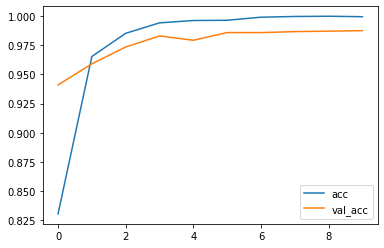

In [110]:
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()

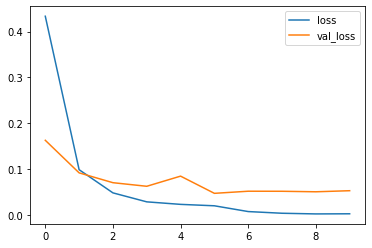

In [111]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [112]:
model.evaluate(x_test_pad, y_test)

76/76 [==============================] - 15s 192ms/step - loss: 0.0531 - accuracy: 0.9876


[0.05308959633111954, 0.9876237511634827]

In [113]:
predict_spam(predict_msg)

 Message: DHL: * Your order # 07u # will * reach you shortly. https://hakurei-shrine.icu/0/?ew8e1um.cnt


'This message is a: Spam'

# **Conclusion**

It is observed that an LSTM algorithm with a dropout layer and upsampling results in best accuracy for the given task. This doesn't mean that other algorithms fail to do their task. But for my given parameters and dataset, the LSTM layer with upsampling and hyperparameters added works the best.